In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Generate Load Time Series

In [2]:
# Simulated time-series (sine wave + noise)
def generate_sine_wave(seq_length, num_samples):
    x = np.linspace(0, 2 * np.pi, seq_length)
    data = [np.sin(x + np.random.rand()) + 0.1 * np.random.randn(seq_length) for _ in range(num_samples)]
    return np.array(data)

seq_length = 50
num_samples = 1000
real_data = generate_sine_wave(seq_length, num_samples)

# Normalize to range [-1, 1]
real_data = (real_data - real_data.min()) / (real_data.max() - real_data.min())
real_data = 2 * real_data - 1

# Torch tensor
real_data = torch.tensor(real_data, dtype=torch.float32)

# Dataloader
batch_size = 32
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Define Generator and Discriminator

In [3]:
class Generator(nn.Module):
    def __init__(self, noise_dim, seq_length):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, seq_length),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, seq_length):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)


Training Setup

In [4]:
noise_dim = 16
generator = Generator(noise_dim, seq_length).to(device)
discriminator = Discriminator(seq_length).to(device)

loss_fn = nn.BCELoss()
lr = 0.0002
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)


Training Loop

In [5]:
epochs = 200
for epoch in range(epochs):
    for batch in dataloader:
        real_seq = batch[0].to(device)
        batch_size = real_seq.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, noise_dim).to(device)
        fake_seq = generator(z)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        d_real_loss = loss_fn(discriminator(real_seq), real_labels)
        d_fake_loss = loss_fn(discriminator(fake_seq.detach()), fake_labels)
        d_loss = d_real_loss + d_fake_loss

        discriminator.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_loss = loss_fn(discriminator(fake_seq), real_labels)

        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch 20, D Loss: 1.2724, G Loss: 0.8187
Epoch 40, D Loss: 1.3970, G Loss: 0.7076
Epoch 60, D Loss: 1.2878, G Loss: 0.7641
Epoch 80, D Loss: 1.3490, G Loss: 0.7274
Epoch 100, D Loss: 1.4377, G Loss: 0.6421
Epoch 120, D Loss: 1.3912, G Loss: 0.7014
Epoch 140, D Loss: 1.3286, G Loss: 0.7354
Epoch 160, D Loss: 1.3680, G Loss: 0.7086
Epoch 180, D Loss: 1.3743, G Loss: 0.6928
Epoch 200, D Loss: 1.3426, G Loss: 0.7369


Visualize generated data

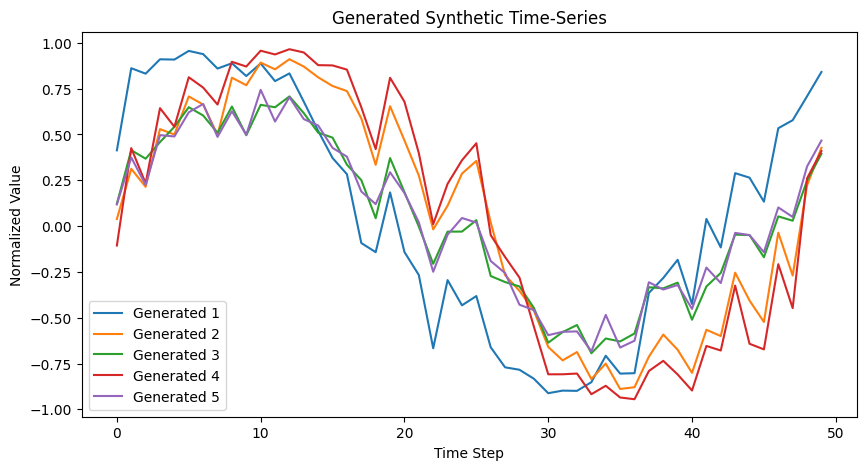

In [7]:
generator.eval()
with torch.no_grad():
    z = torch.randn(5, noise_dim).to(device)
    gen_seq = generator(z).cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(gen_seq[i], label=f"Generated {i+1}")
plt.title("Generated Synthetic Time-Series")
plt.xlabel("Time Step")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()


Real example        

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


Load Real Stock Price Data

In [4]:
# Load stock price data from Yahoo Finance
def load_stock_data(ticker="AAPL", start="2022-01-01", end="2022-12-31"):
    df = yf.download(ticker, start=start, end=end)
    prices = df["Close"].values
    prices = (prices - np.mean(prices)) / np.std(prices)  # Normalize
    return prices

real_data = load_stock_data()
sequence_length = 30

# Create sequences
def create_sequences(data, seq_len):
    sequences = [data[i:i+seq_len] for i in range(len(data)-seq_len)]
    return np.array(sequences)

sequences = create_sequences(real_data, sequence_length)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
sequences

array([[[ 2.07315953],
        [ 1.89401095],
        [ 1.52330938],
        ...,
        [ 1.32316531],
        [ 1.05293673],
        [ 1.07157464]],

       [[ 1.89401095],
        [ 1.52330938],
        [ 1.29685261],
        ...,
        [ 1.05293673],
        [ 1.07157464],
        [ 1.37519467]],

       [[ 1.52330938],
        [ 1.29685261],
        [ 1.31003726],
        ...,
        [ 1.07157464],
        [ 1.37519467],
        [ 1.35655797]],

       ...,

       [[-0.47597004],
        [-0.33868239],
        [-0.43618854],
        ...,
        [-1.72792828],
        [-1.75678639],
        [-1.89953333]],

       [[-0.33868239],
        [-0.43618854],
        [-0.2856416 ],
        ...,
        [-1.75678639],
        [-1.89953333],
        [-2.21076734]],

       [[-0.43618854],
        [-0.2856416 ],
        [-0.24117865],
        ...,
        [-1.89953333],
        [-2.21076734],
        [-1.93229505]]])

Create GAN (Generator & Discriminator) - Modifying code for WGAN-GP

In [18]:
class Generator(nn.Module):
    def __init__(self, noise_dim, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, seq_len)
        )

    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(seq_len, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # No sigmoid here!
        )

    def forward(self, x):
        return self.net(x)


Defining Gradient Penalty

In [19]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp


Train GAN

In [22]:
# Settings
device = "cuda" if torch.cuda.is_available() else "cpu"
noise_dim = 30
batch_size = 32
epochs = 1000

# Prepare data
tensor_data = torch.tensor(sequences, dtype=torch.float32)
loader = DataLoader(TensorDataset(tensor_data), batch_size=batch_size, shuffle=True)

# Models
G = Generator(noise_dim, sequence_length).to(device)
D = Discriminator(sequence_length).to(device)

# Optimizers & loss
# criterion = nn.BCELoss()
# opt_G = torch.optim.Adam(G.parameters(), lr=0.001)
# opt_D = torch.optim.Adam(D.parameters(), lr=0.001)
opt_G = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
opt_D = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))


# Training loop
# for epoch in range(epochs):
#     for real_batch, in loader:
#         real_batch = real_batch.to(device).view(real_batch.size(0), -1)

#         # Train Discriminator
#         z = torch.randn(real_batch.size(0), noise_dim).to(device)
#         fake_batch = G(z)

#         real_labels = torch.ones(real_batch.size(0), 1).to(device)
#         fake_labels = torch.zeros(real_batch.size(0), 1).to(device)

#         D_real = D(real_batch)
#         D_fake = D(fake_batch.detach())
#         loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

#         opt_D.zero_grad()
#         loss_D.backward()
#         opt_D.step()

#         # Train Generator
#         D_fake = D(fake_batch)
#         loss_G = criterion(D_fake, real_labels)  # Fooling the discriminator

#         opt_G.zero_grad()
#         loss_G.backward()
#         opt_G.step()

#     if (epoch+1) % 10 == 0:
#         print(f"Epoch {epoch+1}, Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")



lambda_gp = 10

for epoch in range(epochs):
    for real_batch in loader:
        real = real_batch[0].to(device)
        batch_size = real.size(0)  # Update batch_size dynamically
        real = real.view(batch_size, -1)  # Flatten the input
        batch_size = real.size(0)

        # ======== Train Discriminator ========
        for _ in range(5):  # More D updates per G update
            z = torch.randn(batch_size, noise_dim).to(device)
            fake = G(z).detach()
            d_real = D(real).mean()
            d_fake = D(fake).mean()
            gp = compute_gradient_penalty(D, real.data, fake.data)
            d_loss = -d_real + d_fake + lambda_gp * gp

            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

        # ======== Train Generator ========
        z = torch.randn(batch_size, noise_dim).to(device)
        gen_data = G(z)
        g_loss = -D(gen_data).mean()

        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

    # Logging (optional)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")



Epoch 0 | D_loss: 5.3795 | G_loss: 0.1253
Epoch 100 | D_loss: -3.5900 | G_loss: 0.0836
Epoch 200 | D_loss: -1.8449 | G_loss: -3.2445
Epoch 300 | D_loss: -0.5128 | G_loss: -0.4137
Epoch 400 | D_loss: -0.1225 | G_loss: 1.0988
Epoch 500 | D_loss: -0.8466 | G_loss: 2.1573
Epoch 600 | D_loss: -0.6523 | G_loss: 2.1769
Epoch 700 | D_loss: -0.4612 | G_loss: 2.9996
Epoch 800 | D_loss: -0.8499 | G_loss: 3.6351
Epoch 900 | D_loss: -0.3936 | G_loss: 4.5531


Plot

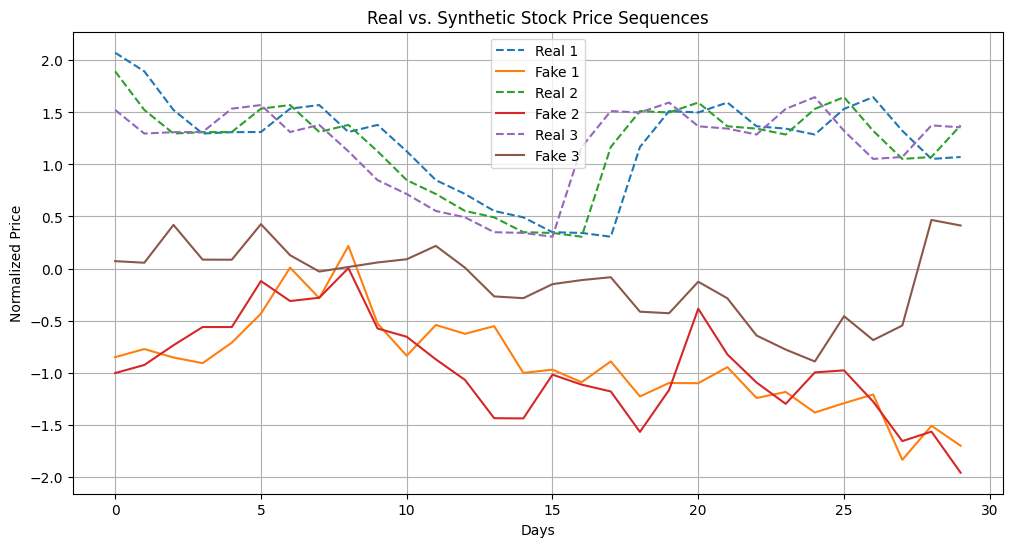

In [44]:
# Generate synthetic sequences
with torch.no_grad():
    z = torch.randn(100, noise_dim).to(device)
    synthetic_sequences = G(z).cpu().numpy()

# Plot a few samples
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(sequences[i], label=f"Real {i+1}", linestyle='dashed')
    plt.plot(synthetic_sequences[i], label=f"Fake {i+1}")
plt.legend()
plt.title("Real vs. Synthetic Stock Price Sequences")
plt.xlabel("Days")
plt.ylabel("Normalized Price")
plt.grid(True)
plt.show()


## Applying TimeGAN

[*********************100%***********************]  1 of 1 completed


Epoch 0 | D_loss: 1.3209 | G_loss: 0.7040


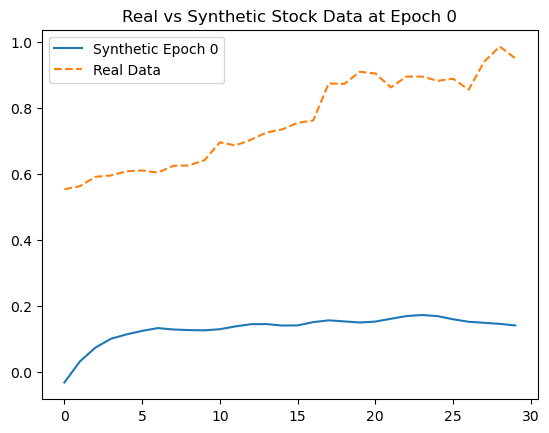

Epoch 100 | D_loss: 1.4862 | G_loss: 0.7259
Epoch 200 | D_loss: 1.4537 | G_loss: 0.7181


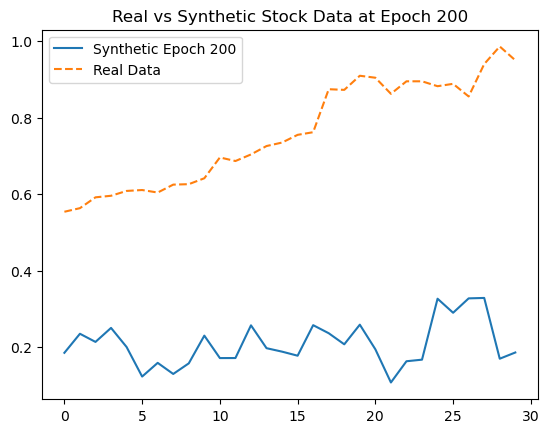

Epoch 300 | D_loss: 1.4203 | G_loss: 0.6780
Epoch 400 | D_loss: 1.2885 | G_loss: 0.7713


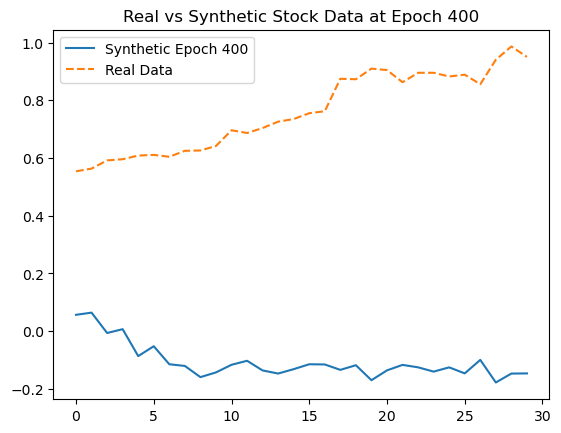

Epoch 500 | D_loss: 1.3215 | G_loss: 0.7094
Epoch 600 | D_loss: 0.0010 | G_loss: 8.8333


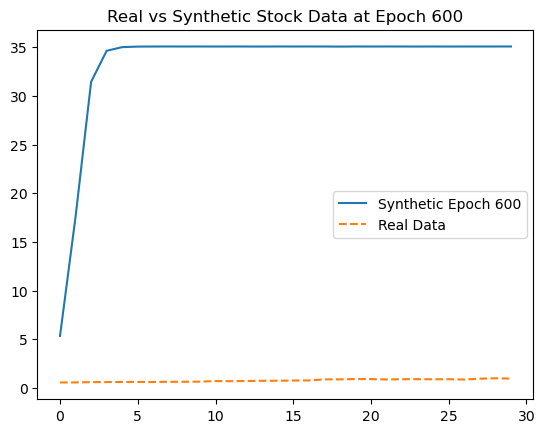

Epoch 700 | D_loss: 0.0010 | G_loss: 7.9868
Epoch 800 | D_loss: 0.0002 | G_loss: 10.3958


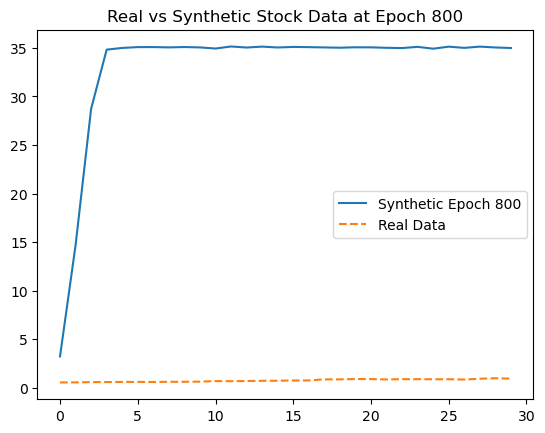

Epoch 900 | D_loss: 0.0001 | G_loss: 10.9215


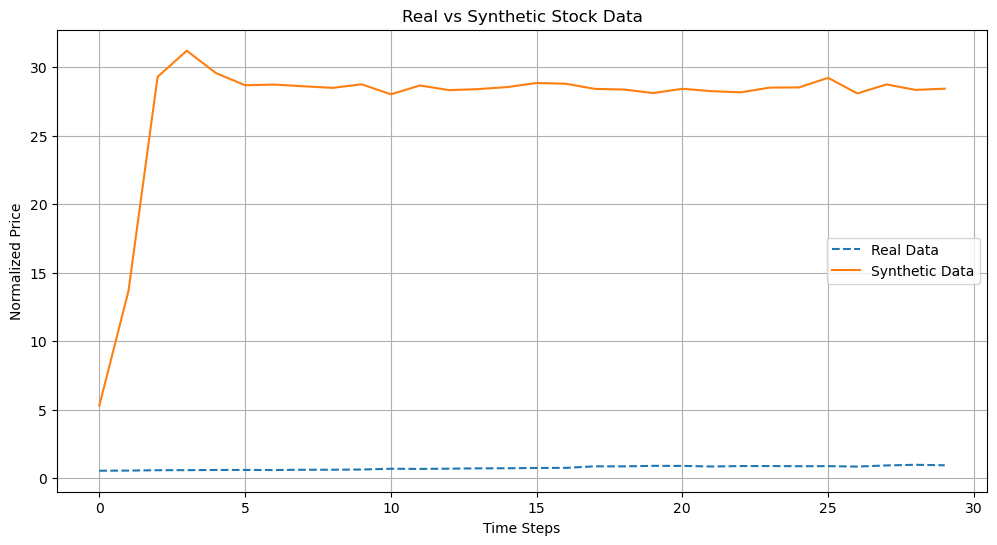

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# 1. Prepare Data
def load_stock_data(ticker="NVDA", start="2020-01-01", end="2022-01-01"):
    df = yf.download(ticker, start=start, end=end)
    prices = df["Close"].values
    prices = prices.reshape(-1, 1)  # Reshape to 2D
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)  # Normalize data
    return scaled_prices

# Load NVIDIA stock data
real_data = load_stock_data()

# Create sequences (example: 30 days of data)
sequence_length = 30
def create_sequences(data, seq_len):
    sequences = [data[i:i+seq_len] for i in range(len(data)-seq_len)]
    return np.array(sequences)

sequences = create_sequences(real_data, sequence_length)
sequences = torch.tensor(sequences, dtype=torch.float32)


# 2. Define Models (Encoder, Generator, Discriminator)

# Encoder: LSTM autoencoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, seq_len)

    def forward(self, x):
        h, (hn, cn) = self.lstm(x)
        z = self.fc(hn[-1])
        return z




# Generator: LSTM generator
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)  # OUTPUT one value per time step

    def forward(self, z):
        h, _ = self.lstm(z)  # shape: [batch_size, seq_len, hidden_dim]
        x_gen = self.fc(h)   # shape: [batch_size, seq_len, input_dim]
        return x_gen


# Discriminator: LSTM discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h, _ = self.lstm(x)
        validity = self.fc(h[:, -1])  # Use last output of LSTM for classification
        return validity

# 3. Initialize Models and Optimizers
input_dim = 1  # Stock prices are a 1D time series
hidden_dim = 64
seq_len = sequence_length
lr = 0.001

encoder = Encoder(input_dim, hidden_dim, seq_len)
generator = Generator(input_dim, hidden_dim, seq_len)
discriminator = Discriminator(input_dim, hidden_dim, seq_len)

optimizer_E = optim.Adam(encoder.parameters(), lr=lr)
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCEWithLogitsLoss()  # For binary classification (real or fake)

# 4. Training Loop (TimeGAN Training)
epochs = 1000
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder.to(device)
generator.to(device)
discriminator.to(device)

sequences = sequences.to(device)

for epoch in range(epochs):
    for i in range(0, len(sequences), batch_size):
        # Create mini-batch
        real_batch = sequences[i:i+batch_size]
        
        # ===== Train Discriminator =====
          # Ensure z has the correct shape
        z = torch.randn(real_batch.size(0), sequence_length, input_dim).to(device)

        fake_batch = generator(z)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(real_batch.size(0), 1).to(device)
        fake_labels = torch.zeros(real_batch.size(0), 1).to(device)

        # Forward pass
        D_real = discriminator(real_batch)
        D_fake = discriminator(fake_batch.detach())

        # Discriminator loss
        D_loss_real = criterion(D_real, real_labels)
        D_loss_fake = criterion(D_fake, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        # Backpropagate discriminator loss
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # ===== Train Generator =====
        D_fake = discriminator(fake_batch)
        G_loss = criterion(D_fake, real_labels)  # Fool the discriminator

        # Backpropagate generator loss
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

    # Optionally, generate synthetic data every 200 epochs
    if epoch % 200 == 0:
        with torch.no_grad():
            z = torch.randn(10, sequence_length, input_dim).to(device)  # Ensure z has the correct shape
            synthetic_data = generator(z).cpu().numpy()
            plt.plot(synthetic_data[0], label=f"Synthetic Epoch {epoch}")
            plt.plot(real_batch[0].cpu().numpy(), label="Real Data", linestyle="--")
            plt.legend()
            plt.title(f"Real vs Synthetic Stock Data at Epoch {epoch}")
            plt.show()

# 5. Evaluate Model (Optional)
with torch.no_grad():
    z = torch.randn(100, sequence_length, input_dim).to(device)
    synthetic_data = generator(z).cpu().numpy()


# Plot synthetic vs real data
plt.figure(figsize=(12, 6))
plt.plot(real_batch[0].cpu().numpy(), label="Real Data", linestyle="--")
plt.plot(synthetic_data[0], label="Synthetic Data", linestyle="-")
plt.legend()
plt.title("Real vs Synthetic Stock Data")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Price")
plt.grid(True)
plt.show()
